In [1]:
path = '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase/'
%cd '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase'

/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase


In [2]:
from dataLoaderCdiff import *
import scipy.stats as st
from collections import Counter
from ml_methods import *
import sklearn
import torch
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime

from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pubchempy as pcp
import pandas as pd
from dataLoader import *
from basic_data_methods import *
from skbio.stats.distance import permanova, DistanceMatrix, anosim
from skbio.stats.distance import mantel
from statsmodels.stats.multitest import multipletests
from matplotlib.collections import LineCollection
from matplotlib import lines

In [3]:
dl_1 = dataLoader(pt_perc=.25, meas_thresh=0, var_perc=15, pt_tmpts=1)
dl_2 = dataLoader(pt_perc=.05, meas_thresh=10, var_perc=5, pt_tmpts=1)

In [4]:
metabs = pd.DataFrame(np.vstack([dl_1.week['metabs'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl_1.week['metabs'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                      columns = dl_1.week['metabs'][0]['x'].columns.values)
met_y = np.concatenate([dl_1.week['metabs'][i]['y'] for i in [0,1,2,3,4]])
met_y_tmpts = np.array([x.split('-')[1] for x in metabs.index.values])

bile_acids = pd.DataFrame(np.vstack([dl_1.week['bile_acids'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl_1.week['bile_acids'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                          columns = dl_1.week['bile_acids'][0]['x'].columns.values)
ba_y = np.concatenate([dl_1.week['bile_acids'][i]['y'] for i in [0,1,2,3,4]])
ba_y_tmpts = np.array([x.split('-')[1] for x in bile_acids.index.values])

counts = np.vstack([dl_2.week_raw['16s'][i]['x'] for i in [0,1,2,3,4]])
proportions = pd.DataFrame(np.divide(counts.T, np.sum(counts, 1)).T, index = \
    np.concatenate([dl_2.week_raw['16s'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                          columns = dl_2.week_raw['16s'][0]['x'].columns.values)
prop_y = np.concatenate([dl_2.week_raw['16s'][i]['y'] for i in [0,1,2,3,4]])
prop_y_tmpts = np.array([x.split('-')[1] for x in proportions.index.values])

# PCA

## Week 1

(184, 184)


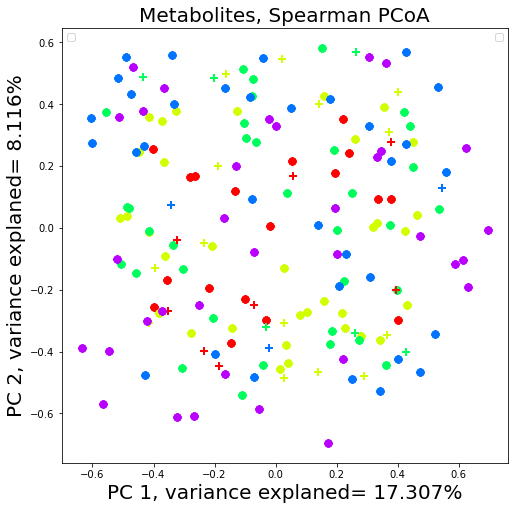

In [5]:
pca_dF, variances, d1 = pcoa_custom(metabs, metric='spearman')
plot_PCA(pca_dF, variances, [met_y_tmpts, met_y], path='paper_figs/pca/metabs_sp_test', target_labels=None, 
         fig_title='Metabolites, Spearman PCoA', colors = None, markers=None)

(26, 26)
(26, 26)
(48, 48)
(47, 47)
(40, 40)
(39, 39)
(36, 36)
(35, 35)


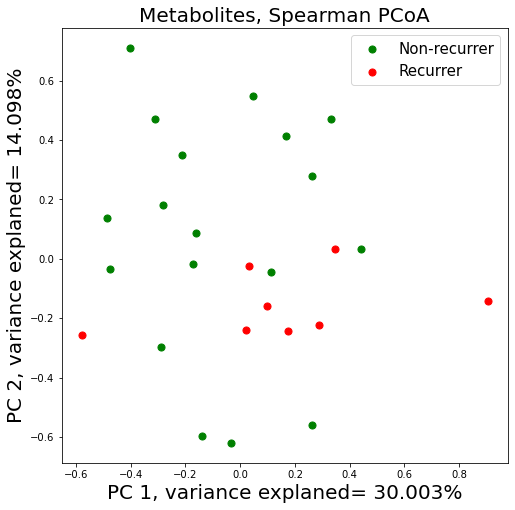

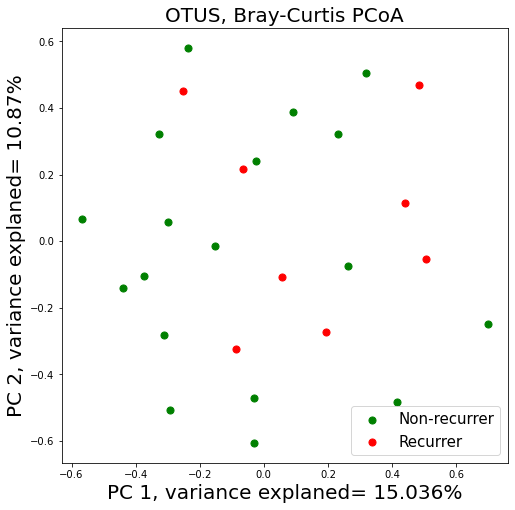

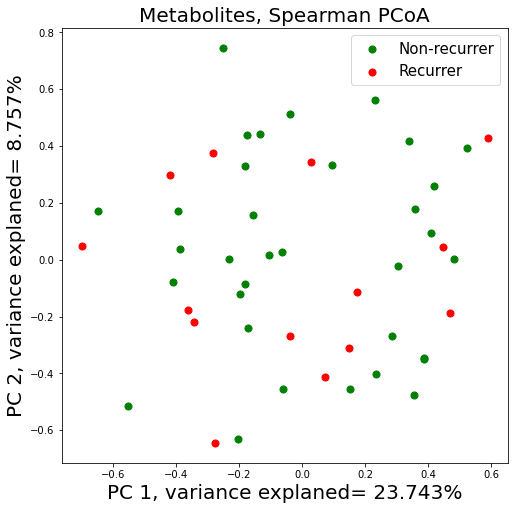

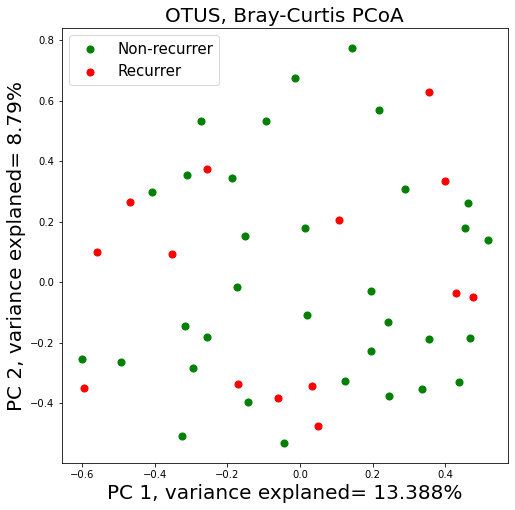

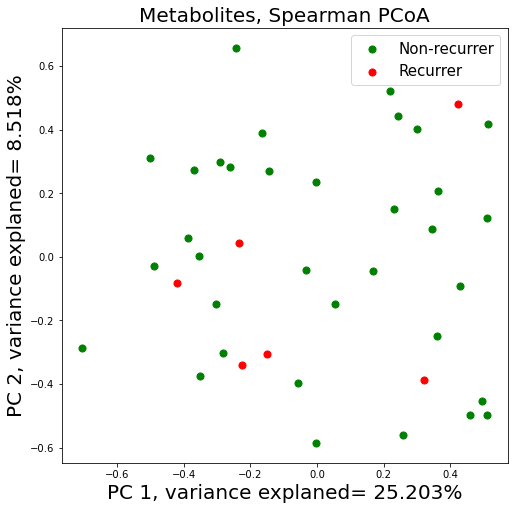

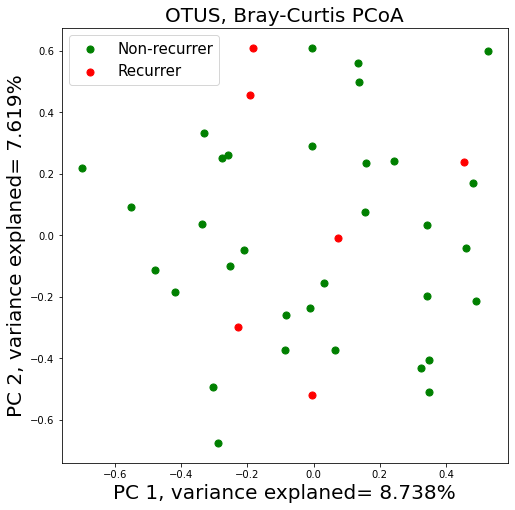

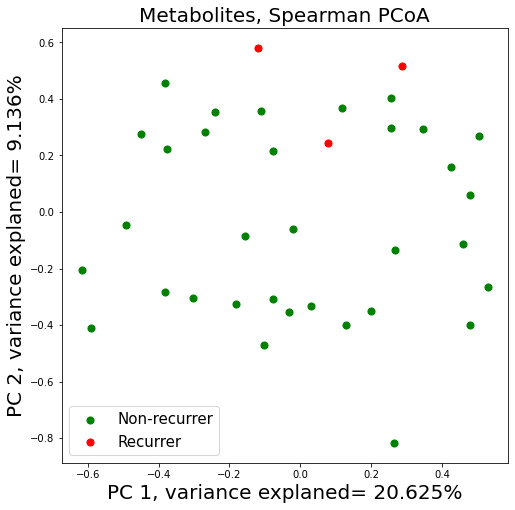

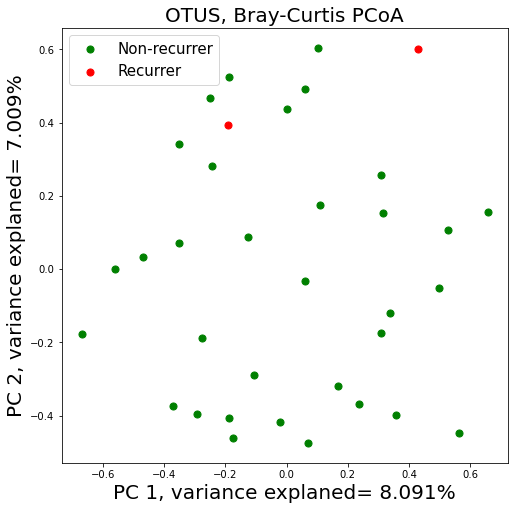

In [6]:
week_dict = {}
week_dict['metabs'] = {}
week_dict['bile_acids'] = {}
week_dict['otus'] = {}
for week in [0,1,2,3]:
    pca_dF, variances, d1 = pcoa_custom(dl_1.week_raw['metabs'][week]['x'], metric='spearman')
    plot_PCA(pca_dF, variances, dl_1.week_raw['metabs'][week]['y'], 
             path='paper_figs/pca/metabs_sp_w' + str(week), target_labels=None, 
             fig_title='Metabolites, Spearman PCoA', colors={
        'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
    week_dict['metabs'][week] = permanova(DistanceMatrix(d1), dl_1.week_raw['metabs'][week]['y'])
    df = dl_1.week_raw['metabs'][week]['x']
    df['outcome'] = dl_1.week_raw['metabs'][week]['y']
    df.to_csv('R analyses/inputs/metabs' + str(week) + '.csv')
    
    pca_dF, variances, d1 = pcoa_custom(dl_2.week_raw['16s'][week]['x'], metric='braycurtis')
    plot_PCA(pca_dF, variances, dl_1.week_raw['16s'][week]['y'], 
             path='paper_figs/pca/otus_sp_w' + str(week), target_labels=None, 
             fig_title='OTUS, Bray-Curtis PCoA', colors={
        'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
    week_dict['otus'][week] = permanova(DistanceMatrix(d1), dl_1.week_raw['16s'][week]['y'])
    df = dl_1.week_raw['16s'][week]['x']
    df['outcome'] = dl_1.week_raw['16s'][week]['y']
    df.to_csv('R analyses/inputs/otus' + str(week) + '.csv')

In [7]:
pd.DataFrame(week_dict).T.to_csv('paper_figs/pca/outcome_byweek_pvals.csv')

(184, 184)
0.001
(184, 184)
0.001
(180, 180)


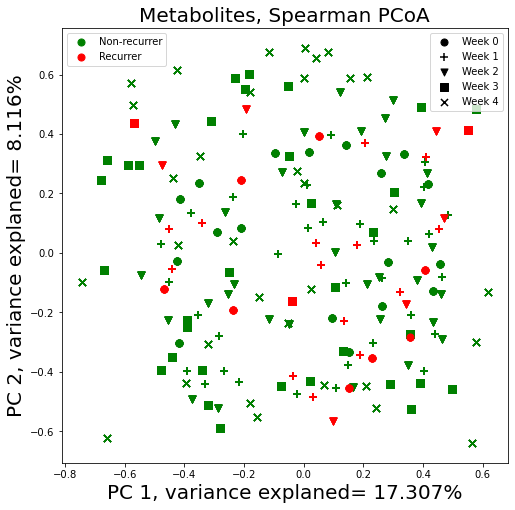

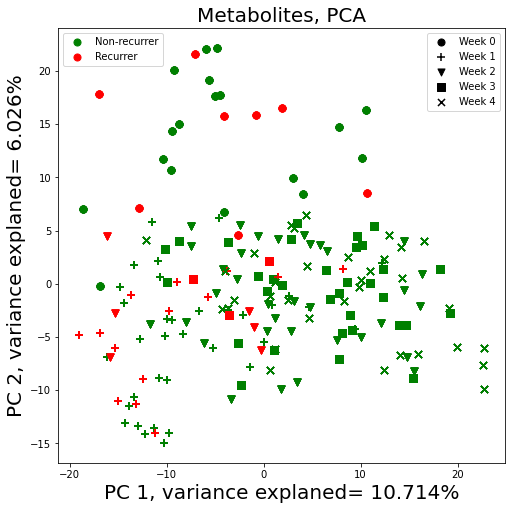

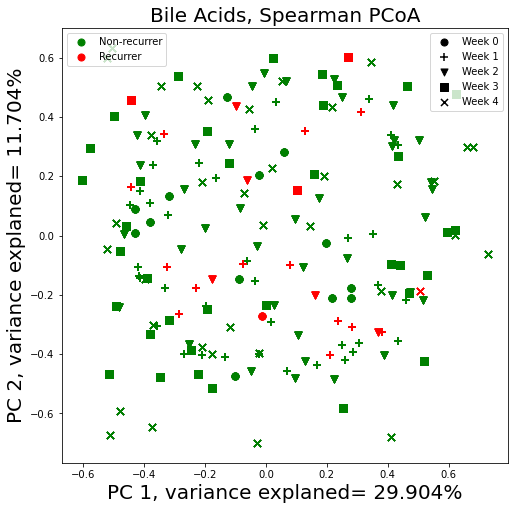

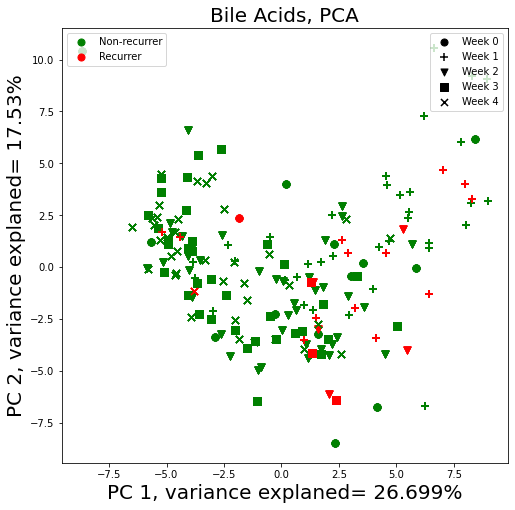

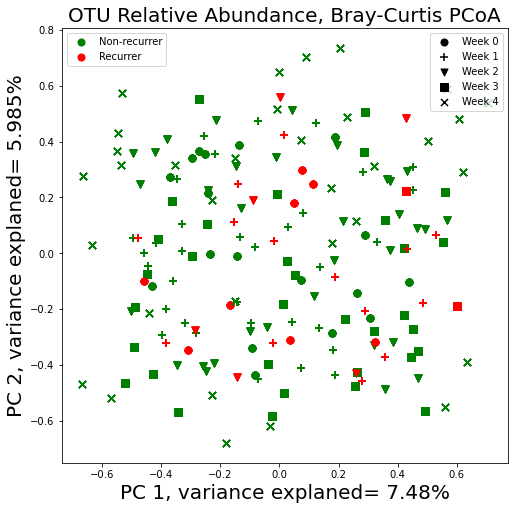

In [8]:
out_dict = {}
tmpt_dict = {}
# PCA
pca_dF, variances, d1 = pcoa_custom(metabs, metric='spearman')
plot_PCA(pca_dF, variances, [met_y, met_y_tmpts], path='paper_figs/pca/metabs_sp', target_labels=None, fig_title='Metabolites, Spearman PCoA', colors={
    'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
np.fill_diagonal(d1, 0)
out_dict["Metab, Spearman"] = permanova(DistanceMatrix(d1), met_y)
tmpt_dict["Metab, Spearman"] = permanova(DistanceMatrix(d1), met_y_tmpts)

metabs_std = standardize(metabs, override = False)
pca_dF, variances, d2 = pcoa_custom(metabs_std, metric='euclidean')
plot_PCA(pca_dF, variances, [met_y, met_y_tmpts], path='paper_figs/pca/metabs_euc', target_labels=None, fig_title='Metabolites, PCA', colors={
    'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
np.fill_diagonal(d2, 0)
out_dict["Metab, Euclidean"] = permanova(DistanceMatrix(d2), met_y)
tmpt_dict["Metab, Euclidean"] = permanova(DistanceMatrix(d2), met_y_tmpts)

r, p, n = mantel(d1, d2, method='spearman', strict=False)
print(p)

pca_dF, variances, d1 = pcoa_custom(bile_acids, metric='spearman')
plot_PCA(pca_dF, variances, [ba_y, ba_y_tmpts], path='paper_figs/pca/bile_acids_sp', target_labels=None, fig_title='Bile Acids, Spearman PCoA', colors={
    'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
np.fill_diagonal(d1, 0)
out_dict["Bile Acids, Spearman"] = permanova(DistanceMatrix(d1), ba_y)
tmpt_dict["Bile Acids, Spearman"] = permanova(DistanceMatrix(d1), ba_y_tmpts)

bile_acids_std = standardize(bile_acids, override=True)
pca_dF, variances, d2 = pcoa_custom(bile_acids_std, metric='euclidean')
plot_PCA(pca_dF, variances, [ba_y, ba_y_tmpts], path='paper_figs/pca/bile_acids_euc', target_labels=None, fig_title='Bile Acids, PCA',
         colors={'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
np.fill_diagonal(d2, 0)
out_dict["Bile Acids, Euclidean"] = permanova(DistanceMatrix(d2), ba_y)
tmpt_dict["Bile Acids, Euclidean"] = permanova(DistanceMatrix(d2), ba_y_tmpts)

r, p, n = mantel(d1, d2, method='spearman', strict=False)
print(p)

pca_dF, variances, d = pcoa_custom(proportions, metric='braycurtis')
plot_PCA(pca_dF, variances, [prop_y, prop_y_tmpts], path='paper_figs/pca/otus', target_labels=None,
         fig_title='OTU Relative Abundance, Bray-Curtis PCoA', colors={
        'Non-recurrer': 'g', 'Recurrer': 'r'}, markers=None)
np.fill_diagonal(d, 0)
out_dict["OTU, Bray-Curtis"] = permanova(DistanceMatrix(d), prop_y)
tmpt_dict["OTU, Bray-Curtis"] = permanova(DistanceMatrix(d), prop_y_tmpts)

In [ ]:
pd.DataFrame(out_dict).T.to_csv('paper_figs/pca/outcome_pvals.csv')

In [ ]:
pd.DataFrame(tmpt_dict).T.to_csv('paper_figs/pca/tmpt_pvals.csv')

# Univariate analysis

In [153]:
dl_1 = dataLoader(pt_perc=.50, meas_thresh=0, var_perc=50, pt_tmpts=1)

In [154]:
dl_1.week['metabs'][1]['x'].shape

(48, 484)

In [155]:
# Univariate analysis
for key in dl_1.week.keys():
    for week in dl_1.week[key].keys():
        if len(np.unique(dl_1.week[key][week]['y_eventually']))<2:
            continue
        if key == '16s':
            continue
        df = rank_sum(dl_1.week[key][week]['x'], dl_1.week[key][week]['y_eventually'])
        df.to_csv('paper_figs/univariate_analysis/' + key + '_' + str(week) + '.csv')
        plt.figure()
        plt.hist(df['P_Val'], bins = np.arange(0,1.05,.05))
        plt.xlabel('p-values')
        plt.ylabel('Frequency')
        plt.title(key + ', week ' + str(week))
        plt.savefig('paper_figs/univariate_analysis/p_vals_' + key + str(week) + '.pdf')
        plt.close()

key = '16s'
for week in dl_2.week[key].keys():
    if len(np.unique(dl_2.week[key][week]['y_eventually'])) < 2:
        continue
    df = rank_sum(dl_2.week[key][week]['x'], dl_2.week[key][week]['y_eventually'], method = 'kruskal')
    df.to_csv('paper_figs/univariate_analysis/kruskal' + key + '_' + str(week) + '.csv')
    plt.figure()
    plt.hist(df['P_Val'], bins = np.arange(0,1.05,.05))
    plt.xlabel('p-values')
    plt.ylabel('Frequency')
    plt.title(key + ', week ' + str(week))
    plt.savefig('paper_figs/univariate_analysis/p_vals_kruskal_' + key + str(week) + '.pdf')
    plt.close()
    
# Univariate analysis
for key in dl_1.week.keys():
    for week in dl_1.week[key].keys():
        if len(np.unique(dl_1.week[key][week]['y_eventually']))<2:
            continue
        if key == '16s':
            continue
        df = rank_sum(dl_1.week[key][week]['x'], dl_1.week[key][week]['y_eventually'], method = 'ttest')
        df.to_csv('paper_figs/univariate_analysis/ttest' + key + '_' + str(week) + '.csv')
        plt.figure()
        plt.hist(df['P_Val'], bins = np.arange(0,1.05,.05))
        plt.xlabel('p-values')
        plt.ylabel('Frequency')
        plt.title(key + ', week ' + str(week))
        plt.savefig('paper_figs/univariate_analysis/p_vals_ttest' + key + str(week) + '.pdf')
        plt.close()

/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jendawk/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/jendawk/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jendawk/miniconda

In [6]:
key = 'metabs'
week = 1
df = rank_sum(dl_1.week[key][week]['x'], dl_1.week[key][week]['y_eventually'])

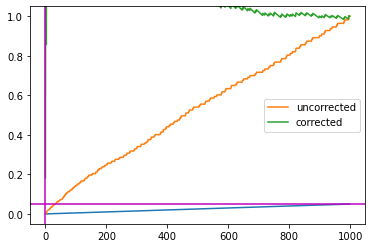

In [24]:
pvals = df['P_Val'].values
ix_sort = np.argsort(pvals)
p_sort = pvals[ix_sort]
vec = .05*(np.arange(1, len(pvals)+1)/len(pvals))
try:
    L = np.max(np.where(p_sort <= vec)[0])
except:
    L = 0
plt.plot(vec)
plt.plot(p_sort, label = 'uncorrected')
plt.plot((p_sort)/(vec/.05), label = 'corrected')
plt.axhline(y = .05, c = 'm')
plt.axvline(x = L, c = 'm')
plt.ylim([-.05,1.05])
plt.legend()

# Entropy

In [50]:
def normalized_entropy(counts):
    '''Calculate the normailized entropy
    Entropy is defined as
        E = - \sum_i (b_i * \log_n(b_i))
    where
        b_i is the relative abundance of the ith ASV
    Parameters
    ----------
    counts (array_like)
        - Vector of counts
    Returns
    -------
    double
    '''
#     counts = _validate_counts(counts)
    rel = counts[counts>0]
    rel = rel / np.sum(rel)
    a = rel * np.log(rel)
    a = -np.sum(a) / np.log(len(rel))
#     a = -np.sum(a)
    return a

In [10]:
entropy_df = {i: pd.DataFrame({'Week ' + str(i): [normalized_entropy(dl_2.week_raw['16s'][i]['x'].loc[k,:]) for k in dl_2.week_raw['16s'][i]['x'].index.values], 'Outcome': dl_2.week_raw['16s'][i]['y_eventually']}) for i in dl_2.week_raw['16s'].keys()}

KeyError: 'y_eventually'

In [9]:
tmpts = [0,1,1.5,2]
pval = {}
pvals = []
for cl in ['Recurrer','Non-recurrer']:
    pval[cl] = {}
    for tmpt in tmpts:
        entropy_1 = entropy_df[tmpt]
        entropy_2 = entropy_df[tmpt + 1]
        entropy_1 = entropy_1.loc[entropy_1['Outcome'] == cl]
        entropy_2 = entropy_2.loc[entropy_2['Outcome'] == cl]
        ix_sim = set(entropy_1.index.values).intersection(set(entropy_2.index.values))
        try:
            _, p = st.wilcoxon(entropy_1.loc[ix_sim]['Week ' + str(tmpt)], 
                                                      entropy_2.loc[ix_sim]['Week ' + str(tmpt+1)],
                                                     alternative = 'two-sided')
            pval[cl][(tmpt, tmpt+1)] = p
            pvals.append(p)
        except:
            continue
pval_corr = {}
pvals_corr = multipletests(pvals, alpha = 0.05, method = 'fdr_bh')
it = 0
for cl in ['Recurrer','Non-recurrer']:
    pval_corr[cl] = {}
    for tmpt in tmpts:
        pval_corr[cl][(tmpt, tmpt+1)] = pvals_corr[it]
        it += 1
# p_df = pd.DataFrame(pval, index = [0]).T
# p_df.to_csv('paper_figs/entropy_ttest.csv')
pd.DataFrame({'Uncorrected': pval, 'Corrected': pval_corr}).to_csv('paper_figs/entropy_wilcoxon.csv')

NameError: name 'entropy_df' is not defined

In [144]:
tmpts = [0,1,1.5,2]
pval = {}
outcome= ['Recurrer','Non-recurrer']
for tmpt in tmpts:
    entropy = entropy_df[tmpt]
    entropy_1 = entropy.loc[entropy['Outcome'] == outcome[0]]
    entropy_2 = entropy.loc[entropy['Outcome'] == outcome[1]]
    try:
        _, pval[tmpt] = st.mannwhitneyu(entropy_1['Week ' + str(tmpt)], 
                                                  entropy_2['Week ' + str(tmpt)],
                                                 alternative = 'two-sided')
    except:
        continue
pval_corr = {t: p for t, p in zip(tmpts, multipletests(list(pval.values()), alpha = 0.05, method = 'fdr_bh'))

# p_df = pd.DataFrame(pval, index = [0]).T
# p_df.to_csv('paper_figs/entropy_ttest.csv')
pd.DataFrame({'Uncorrected': pval, 'Corrected': pval_corr}).T.to_csv('paper_figs/entropy_mann_whit.csv')

(array([False, False,  True, False]), array([0.36052592, 0.40211628, 0.01208732, 0.36052592]), 0.012741455098566168, 0.0125)


In [7]:
from skbio.diversity.alpha import ace, chao1, shannon, berger_parker_d, brillouin_d, dominance, doubles, enspie, fisher_alpha
from skbio.diversity.alpha import goods_coverage, heip_e, kempton_taylor_q, lladser_pe, margalef, mcintosh_d, mcintosh_e
from skbio.diversity.alpha import menhinick, observed_otus, osd, pielou_e, robbins, simpson, simpson_e, singles, strong

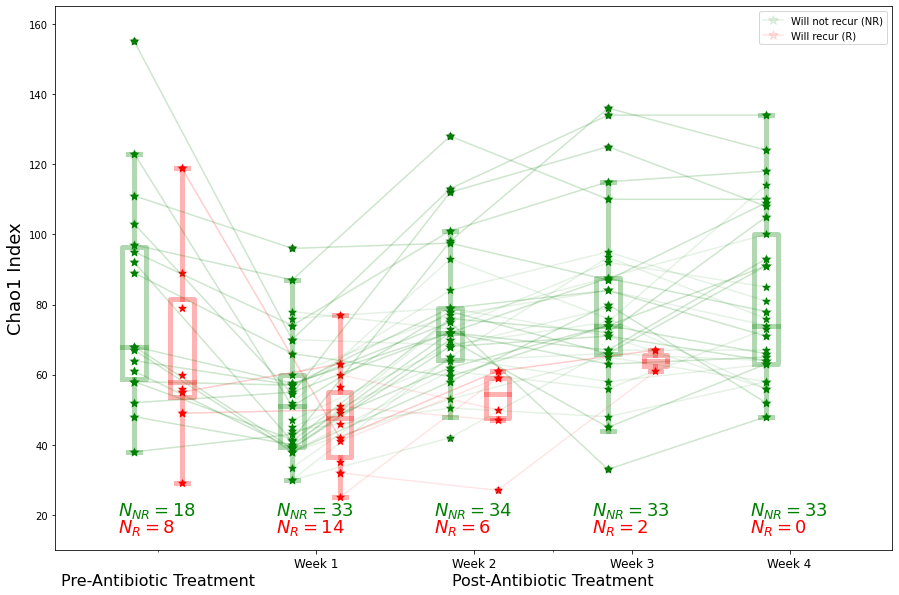

In [143]:
# Entropy
fig, ax = plt.subplots(figsize = (15,10))
pts = entropy_f[1].index.values
pts0 = entropy_f[0].index.values
pts_full = np.concatenate((pts, pts0))
# for cl in ['Non-recurrer','Recurrer']
# for key, val in entropy_f.items():
rec = 0
n_rec = 0
c_rec = []
c_nrec = []
c_rec_dict = {}

for key, val in entropy_f.items():
    ax.text(key - .25, 20, r'$N_{NR} = $' + str(sum(val['Outcome']=='Non-recurrer')), fontsize = 18, color = 'g')
    ax.text(key - .25, 15, r'$N_{R} = $' + str(sum(val['Outcome']=='Recurrer')), fontsize = 18, color = 'r')
    box1 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Non-recurrer'], positions = [key-0.15])
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box1[element], color='g', linewidth = 5, alpha = 0.3)
    box2 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Recurrer'], positions = [key+.15])
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box2[element], color='r', linewidth = 5, alpha = 0.3)
        
for pt in pts_full:
    keys = [key for key in entropy_f.keys() if pt in entropy_f[key].index.values]
    vals = [entropy_f[key]['Week ' + str(key)][pt] for key in keys]
    if pt in entropy_f[1].index.values:
        df_to_check = entropy_f[1]
    elif pt in entropy_f[0].index.values:
        df_to_check = entropy_f[0]
        
    
    if df_to_check['Outcome'][pt] == 'Recurrer':
        c_rec_dict[pt] = keys
        c_rec.extend(keys)
        keys = np.array(keys)
        if rec == 0:
            ax.plot(keys+.15, vals, '*-',ms = 10,c = 'r', alpha = 0.1, label = 'Will recur (R)')
            rec += 1
        else:
            ax.plot(keys+.15, vals, '*-',ms = 10,c = 'r', alpha = 0.1)
        ax.scatter(keys+.15, vals, marker='*',s = 50,c = 'r')
    elif df_to_check['Outcome'][pt] == 'Non-recurrer':
        c_nrec.extend(keys)
        keys = np.array(keys)
        if n_rec == 0:
            ax.plot(keys - .15, vals, '*-',ms = 10, c = 'g', alpha = 0.1, label = 'Will not recur (NR)')
            n_rec += 1
        else:
            ax.plot(keys - .15, vals, '*-',ms = 10,c = 'g', alpha = 0.1)
        ax.scatter(keys-.15, vals, marker='*',s = 50,c = 'g')

ax.set_ylim([10,165])
ax.set_xticks([1,2,3,4])
ax.set_xticks([0, 2.5], minor = True)
ax.grid( False, axis='x' )
ax.grid( False, axis='x', which='minor' )

        
ax.set_xticklabels(labels=['Week 1','Week 2', 'Week 3','Week 4'], 
                   #rotation = 10,  ha = 'center', 
                  minor = False, fontsize = 12)
ax.set_xticklabels(labels = ['\nPre-Antibiotic Treatment','\nPost-Antibiotic Treatment'], 
                   minor = True, fontsize = 16)

plt.ylabel('Chao1 Index', fontsize = 18)
plt.legend()

# ax.annotate('', xy=(2.5, 10), xycoords='axes fraction', 
#              ha='center', va='bottom',
#             arrowprops=dict(arrowstyle=']-, widthB=4.0, lengthB=1.5', lw=2.0))
plt.savefig('paper_figs/entropy_over_time.pdf')


In [82]:
from collections import Counter
print(Counter(c_nrec))
print(Counter(c_rec))

Counter({1: 51, 2: 51, 3: 50, 4: 50, 0: 36})
Counter({1: 17, 0: 11, 2: 7, 3: 3})


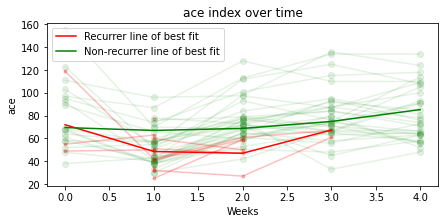

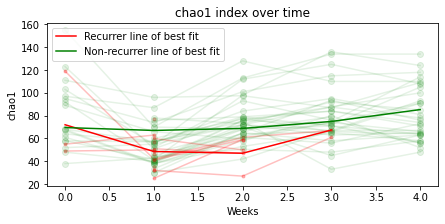

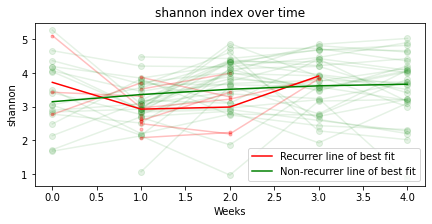

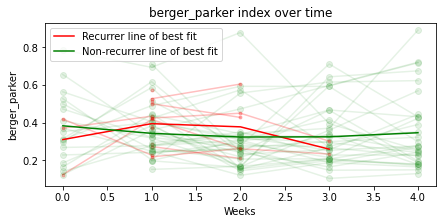

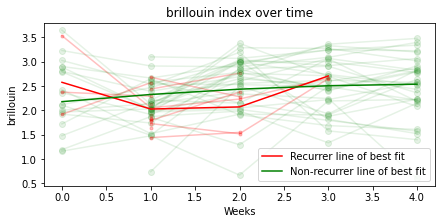

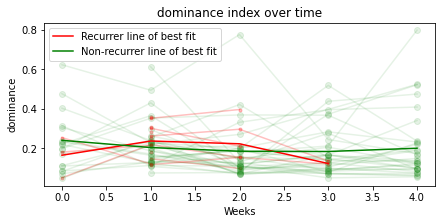

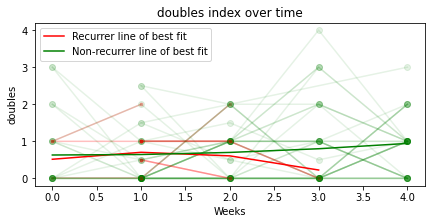

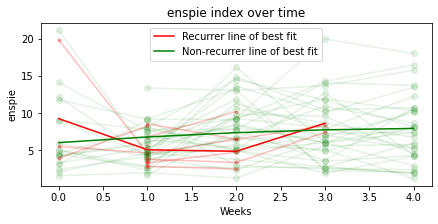

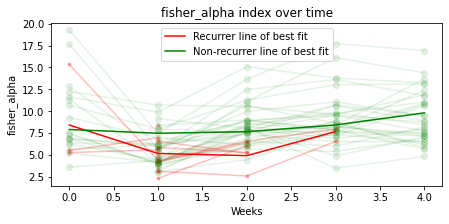

/Users/jendawk/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


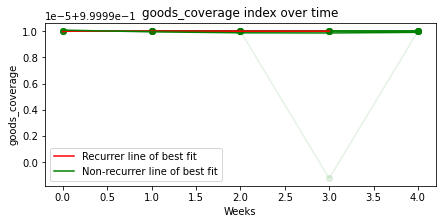

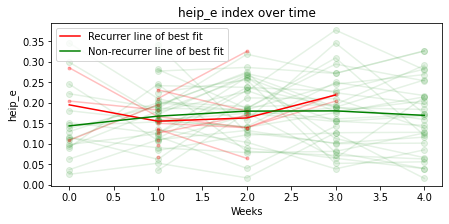

/Users/jendawk/miniconda3/lib/python3.7/site-packages/skbio/diversity/alpha/_base.py:441: RuntimeWarning: invalid value encountered in long_scalars
  sorted_counts[lower])


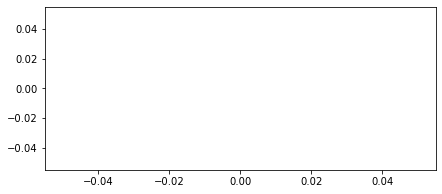

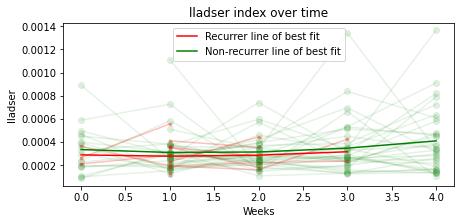

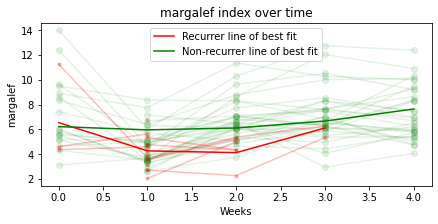

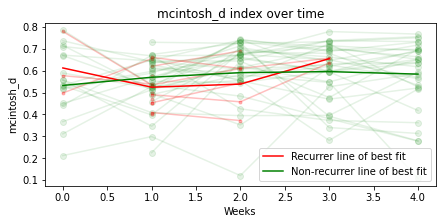

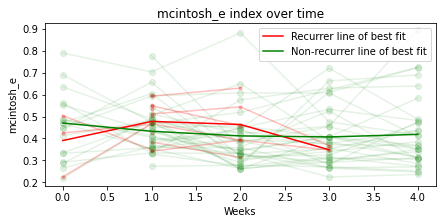

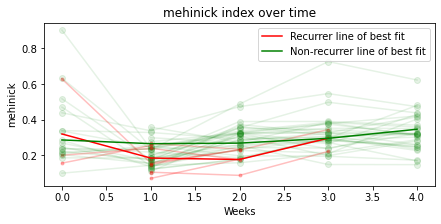

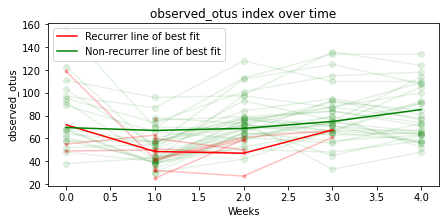

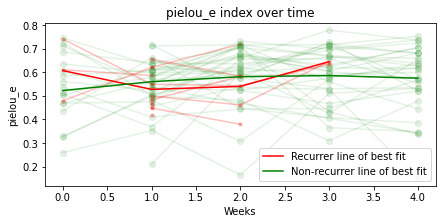

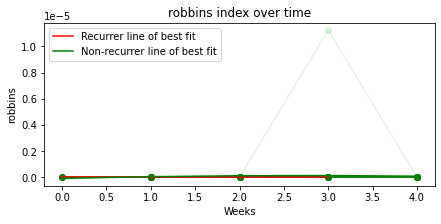

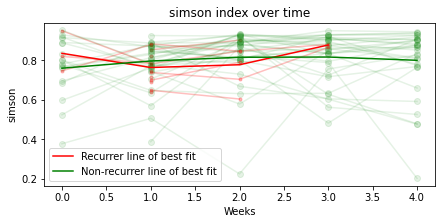

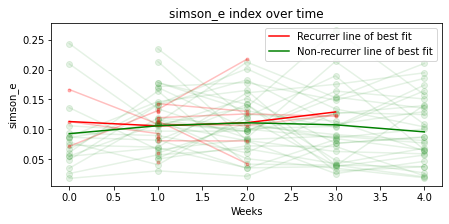

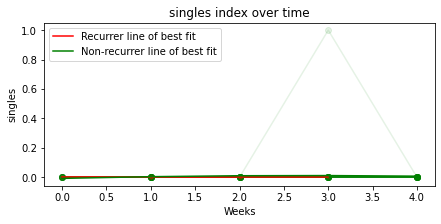

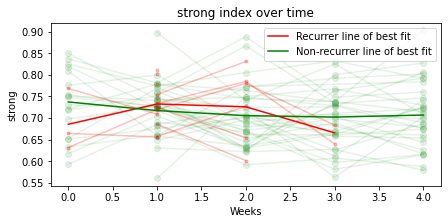

In [118]:
ddict = {'ace':ace, 'chao1': chao1, 'shannon':shannon,'berger_parker': berger_parker_d, 'brillouin': brillouin_d, 
         'dominance': dominance, 'doubles': doubles, 'enspie': enspie, 'fisher_alpha': fisher_alpha,
        'goods_coverage': goods_coverage, 'heip_e': heip_e, 'kempton_taylor': kempton_taylor_q, 
         'lladser': lladser_pe, 'margalef': margalef, 'mcintosh_d': mcintosh_d, 'mcintosh_e': mcintosh_e,
        'mehinick': menhinick, 'observed_otus':observed_otus, 'osd': osd, 'pielou_e': pielou_e, 
         'robbins': robbins, 'simson':simpson, 'simson_e':simpson_e, 'singles':singles, 'strong':strong}

# ddict = {'ace':ace, 'chao1': chao1,  
#           'fisher_alpha': fisher_alpha,
#           'margalef': margalef, 
#         'mehinick': menhinick, 'observed_otus':observed_otus}
for mname, measure_type in ddict.items():
    try:
        entropy_df = {i: pd.DataFrame({'Week ' + str(i): [measure_type(dl_2.week_raw['16s'][i]['x'].loc[k,:]) 
                                                          for k in dl_2.week_raw['16s'][i]['x'].index.values], 
                                       'Outcome': dl_2.week_raw['16s'][i]['y_eventually']}) for i in dl_2.week_raw['16s'].keys()}
        bins = [i for i in entropy_df.keys() if isinstance(i, int)]

        entropy_f = {}
        for b in bins:

            b1 = entropy_df[b]
            if b +.5 not in entropy_df.keys():
                entropy_f[b] = entropy_df[b]
                continue
            b2 = entropy_df[b + .5]
            ix_sim = list(set(b1.index.values).intersection(set(b2.index.values)))
            ix_all = np.concatenate((b1.index.values,b2.index.values))
            df = pd.DataFrame(index = np.unique(ix_all), columns = ['Week ' + str(b), 'Outcome'])
            df['Outcome'][b1.index.values] = b1['Outcome']
            df['Outcome'][b2.index.values] = b2['Outcome']

            df['Week '+ str(b)][b1.index.values] = b1['Week ' + str(b)]
            df['Week '+ str(b)][b2.index.values] = b2['Week ' + str(b+0.5)]

            b_together = (b1['Week ' + str(b)][ix_sim] + b2['Week ' + str(b+0.5)][ix_sim])/2
            df['Week '+ str(b)][ix_sim] = b_together

            entropy_f[b] = df
            # Entropy
        fig, ax = plt.subplots(figsize = (7,3))
        pts = entropy_f[1].index.values
        # for cl in ['Non-recurrer','Recurrer']
        # for key, val in entropy_f.items():
        rec = 0
        n_rec = 0
        x_r = []
        y_r = []
        x_c = []
        y_c = []
        for pt in pts:
            keys = [key for key in entropy_f.keys() if pt in entropy_f[key].index.values]
            vals = [entropy_f[key]['Week ' + str(key)][pt] for key in keys]

            if entropy_f[1].loc[pt]['Outcome'] == 'Recurrer':
                ax.plot(keys, vals, c = 'r', alpha = 0.25, marker = '.')

                x_r.extend(keys)
                y_r.extend(vals)

            elif entropy_f[1].loc[pt]['Outcome'] == 'Non-recurrer':
                ax.plot(keys, vals, c = 'g', alpha = 0.1, marker = 'o')
                x_c.extend(keys)
                y_c.extend(vals)
        sort_ix = np.argsort(x_r)
        x_r = np.array(x_r)
        x_c = np.array(x_c)
        y_r = np.array(y_r)
        y_c = np.array(y_c)

    # trend = np.polyfit(x_r[sort_ix], y_r[sort_ix],2)
    # trendpoly = np.poly1d(trend) 
    # ax.plot(x_r, trendpoly(x_r), c = 'r')

        popt, pcov = scipy.optimize.curve_fit(func, x_r[sort_ix], y_r[sort_ix])
        ax.plot(x_r[sort_ix], func(x_r[sort_ix], *popt), c='r', label = 'Recurrer line of best fit')

        sort_ix = np.argsort(x_c)

        # trend = np.polyfit(x_c[sort_ix], y_c[sort_ix],2)
        # trendpoly = np.poly1d(trend) 
        # ax.plot(x_c, trendpoly(x_c), c = 'g')

        popt, pcov = scipy.optimize.curve_fit(func, x_c[sort_ix], y_c[sort_ix])
        ax.plot(x_c[sort_ix], func(x_c[sort_ix], *popt), c = 'g', label = 'Non-recurrer line of best fit')
        ax.set_title(mname + ' index over time')
        ax.set_xlabel('Weeks')
        ax.set_ylabel(mname)
        plt.legend()
        plt.show()
    except:
        continue

In [87]:
def func(x,a,b,c):
    return a*x + b*(x**2) + c

In [8]:
entropy_df = {i: pd.DataFrame({'Week ' + str(i): [chao1(dl_2.week_raw['16s'][i]['x'].loc[k,:]) for k in dl_2.week_raw['16s'][i]['x'].index.values], 'Outcome': dl_2.week_raw['16s'][i]['y_eventually']}) for i in dl_2.week_raw['16s'].keys()}

In [9]:
bins = [i for i in entropy_df.keys() if isinstance(i, int)]

entropy_f = {}
for b in bins:
    
    b1 = entropy_df[b]
    if b +.5 not in entropy_df.keys():
        entropy_f[b] = entropy_df[b]
        continue
    b2 = entropy_df[b + .5]
    ix_sim = list(set(b1.index.values).intersection(set(b2.index.values)))
    ix_all = np.concatenate((b1.index.values,b2.index.values))
    df = pd.DataFrame(index = np.unique(ix_all), columns = ['Week ' + str(b), 'Outcome'])
    df['Outcome'][b1.index.values] = b1['Outcome']
    df['Outcome'][b2.index.values] = b2['Outcome']
    
    df['Week '+ str(b)][b1.index.values] = b1['Week ' + str(b)]
    df['Week '+ str(b)][b2.index.values] = b2['Week ' + str(b+0.5)]
    
    b_together = (b1['Week ' + str(b)][ix_sim] + b2['Week ' + str(b+0.5)][ix_sim])/2
    df['Week '+ str(b)][ix_sim] = b_together
    
    entropy_f[b] = df

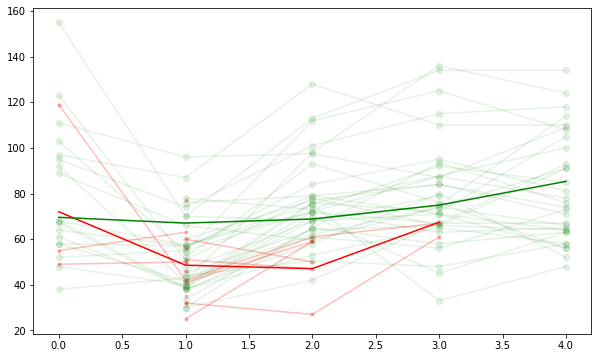

In [127]:
# Entropy
fig, ax = plt.subplots(figsize = (10,6))
pts = entropy_f[1].index.values
# for cl in ['Non-recurrer','Recurrer']
# for key, val in entropy_f.items():
rec = 0
n_rec = 0
x_r = []
y_r = []
x_c = []
y_c = []
for pt in pts:
    keys = [key for key in entropy_f.keys() if pt in entropy_f[key].index.values]
    vals = [entropy_f[key]['Week ' + str(key)][pt] for key in keys]
    
    if entropy_f[1].loc[pt]['Outcome'] == 'Recurrer':
        if rec == 0:
            ax.plot(keys, vals, c = 'r', alpha = 0.25, marker = '.', label = 'Recurrer')
            rec += 1
        else:
            ax.plot(keys, vals, c = 'r', alpha = 0.25, marker = '.')
            
        x_r.extend(keys)
        y_r.extend(vals)

    elif entropy_f[1].loc[pt]['Outcome'] == 'Non-recurrer':
        if n_rec == 0:
            ax.plot(keys, vals, c = 'g', alpha = 0.1, marker = 'o', label = 'Non-recurrer')
            n_rec += 1
        else:
            ax.plot(keys, vals, c = 'g', alpha = 0.1, marker = 'o')
        x_c.extend(keys)
        y_c.extend(vals)
sort_ix = np.argsort(x_r)
x_r = np.array(x_r)
x_c = np.array(x_c)
y_r = np.array(y_r)
y_c = np.array(y_c)

# trend = np.polyfit(x_r[sort_ix], y_r[sort_ix],2)
# trendpoly = np.poly1d(trend) 
# ax.plot(x_r, trendpoly(x_r), c = 'r')

popt, pcov = scipy.optimize.curve_fit(func, x_r[sort_ix], y_r[sort_ix])
ax.plot(x_r[sort_ix], func(x_r[sort_ix], *popt), c='r')

sort_ix = np.argsort(x_c)

# trend = np.polyfit(x_c[sort_ix], y_c[sort_ix],2)
# trendpoly = np.poly1d(trend) 
# ax.plot(x_c, trendpoly(x_c), c = 'g')

popt, pcov = scipy.optimize.curve_fit(func, x_c[sort_ix], y_c[sort_ix])
ax.plot(x_c[sort_ix], func(x_c[sort_ix], *popt), c = 'g')

In [39]:
sets = [list(set(entropy_f[i].index.values).intersection(set(entropy_f[i+1].index.values))) for i in list(entropy_f.keys())[:-1]]
entropy_f_delta = {i:entropy_f[i+1]['Week ' + str(i+1)].loc[sets[i]] - entropy_f[i]['Week ' + str(i)].loc[sets[i]] for i in list(entropy_f.keys())[:-1]}
entropy_delta = copy.deepcopy(entropy_f)
for key in list(entropy_f.keys())[:-1]:
    entropy_delta[key]['Week ' + str(key)] = entropy_f_delta[key]

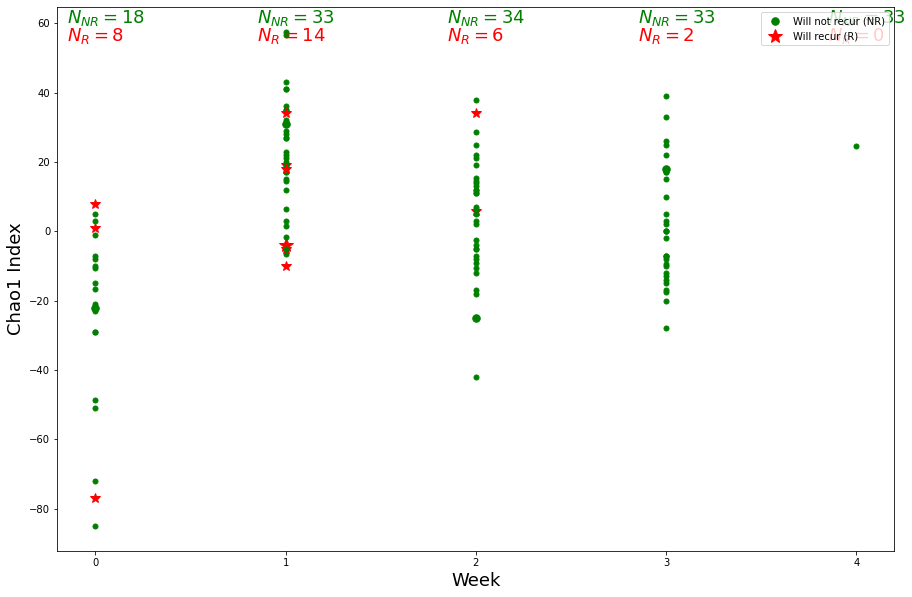

In [43]:
# Delta Entropy
fig, ax = plt.subplots(figsize = (15,10))
pts = entropy_f[1].index.values
# for cl in ['Non-recurrer','Recurrer']
# for key, val in entropy_f.items():
rec = 0
n_rec = 0
v_r = []
v_nr = []
for pt in pts:
    keys0 = [key for key in entropy_f.keys() if pt in entropy_f[key].index.values]
    vals0 = [entropy_f[key]['Week ' + str(key)][pt] for key in keys0]
    
    keys = ['T' + str(keys0[i+1]) + ' - T' + str(keys0[i]) for i in range(len(keys0[:-1]))]
    vals = [vals0[i+1]-vals0[i] for i in range(len(vals0[:-1]))]
    
    if entropy_f[1].loc[pt]['Outcome'] == 'Recurrer':
        if rec == 0:
            ax.plot(keys, vals, '*', c = 'r', label = 'Will recur (R)', ms = 15)
            rec += 1
        else:
            ax.plot(keys, vals, '*', c = 'r', ms = 10)
        v_r.append(vals)
    elif entropy_f[1].loc[pt]['Outcome'] == 'Non-recurrer':
        if n_rec == 0:
            ax.plot(keys, vals, '.', c = 'g', label = 'Will not recur (NR)', ms = 15)
            n_rec += 1
        else:
            ax.plot(keys, vals, '.', c = 'g', ms = 10)
#     ax.set_ylim([0,1])

for key, val in entropy_delta.items():
    ax.text(key - .15, 60, r'$N_{NR} = $' + str(sum(val['Outcome']=='Non-recurrer')), fontsize = 18, color = 'g')
    ax.text(key - .15, 55, r'$N_{R} = $' + str(sum(val['Outcome']=='Recurrer')), fontsize = 18, color = 'r')
#     box1 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Non-recurrer'], positions = [key-0.15])
#     for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#         plt.setp(box1[element], color='g', linewidth = 3)
#     box2 = ax.boxplot(val['Week ' + str(key)].loc[val['Outcome']=='Recurrer'], positions = [key+.15])
#     for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#         plt.setp(box2[element], color='r', linewidth = 3)
        
plt.setp(ax, xticks=[0,1,2,3,4], xticklabels=[0,1,2,3,4])
plt.ylabel('Chao1 Index', fontsize = 18)
plt.xlabel('Week', fontsize = 18)
plt.legend()
plt.savefig('paper_figs/delta_entropy_over_time.pdf')

/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/jendawk/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

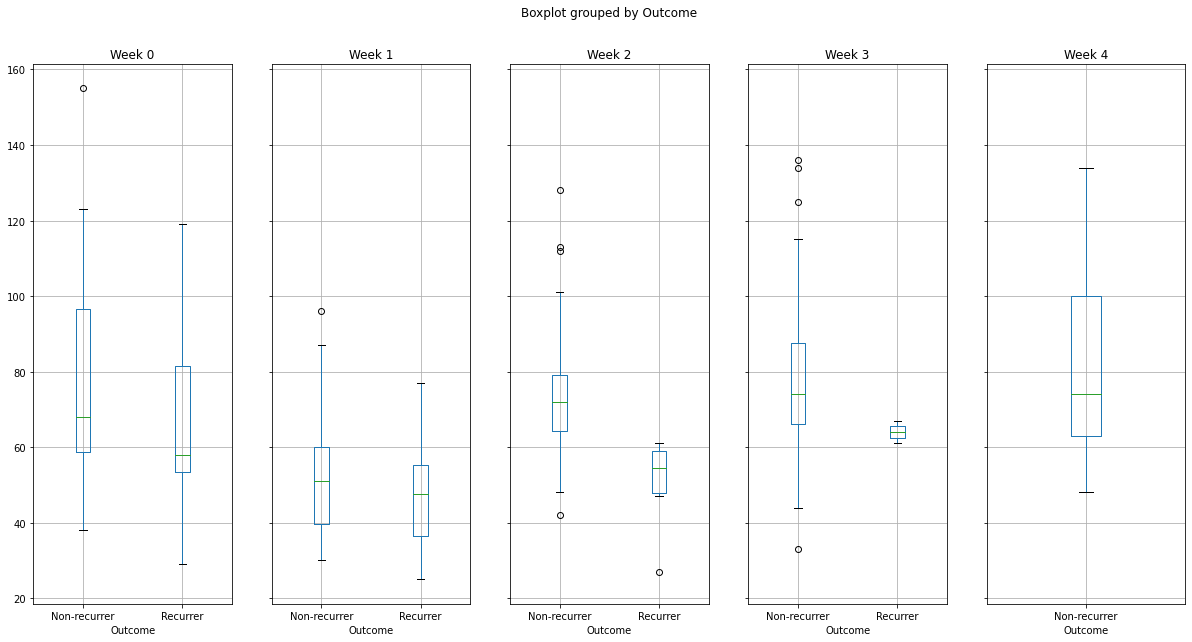

In [137]:
# Entropy
fig, ax = plt.subplots(1,5,figsize = (20,10), sharey = True)
for key, val in entropy_f.items():
    val.boxplot(column = 'Week ' + str(key), by = 'Outcome', ax = ax[key])
    
plt.savefig('paper_figs/entropy.pdf')

In [ ]:
tmpts = [0,1,2,3]
outcomes = ['Cleared', 'Recur']
all_targs = np.concatenate([list(zip(outcomes, x)) for x in itertools.permutations(tmpts, len(outcomes))])
entropy_to_tst = {tuple(targ): entropy_df[int(targ[1])]['Week ' + targ[1]].loc[entropy_df[int(targ[1])]['Outcome'] == targ[0]] for targ in all_targs}
pval = {}
for df1, df2 in itertools.combinations(entropy_to_tst.keys(), 2):
    try:
        _, pval[str((df1, df2))] = st.mannwhitneyu(x = entropy_to_tst[df1], y = entropy_to_tst[df2])
    except:
        continue
p_df = pd.DataFrame(pval, index = [0])
p_df.to_csv('paper_figs/entropy_ttest.csv')

# Heatmaps

In [51]:
from Bio import Phylo
import re

In [157]:
data = dl_1.keys['metabs']['filtered_data']
metabs = data.columns.values

col_mat_df = dl_1.col_mat_mets.set_index('BIOCHEMICAL')
col_mat_df = col_mat_df.loc[metabs]
col_mat_sorted = col_mat_df.sort_values(by = ['SUPER_PATHWAY','SUB_PATHWAY'])

biochem_sorted = col_mat_sorted.index.values

In [4]:
def get_dendrogram(data):

    metabs = data.columns.values

    col_mat_df = dl_1.col_mat_mets.set_index('BIOCHEMICAL')
    col_mat_df = col_mat_df.loc[metabs]
    col_mat_sorted = col_mat_df.sort_values(by = ['SUPER_PATHWAY','SUB_PATHWAY'])

    biochem_sorted = col_mat_sorted.index.values
    df_dendro = col_mat_sorted[['SUPER_PATHWAY','SUB_PATHWAY']].astype('category')
    
    df_dist = pd.DataFrame(np.zeros((df_dendro.shape[0], df_dendro.shape[0])), index = df_dendro.index.values, columns = 
                          df_dendro.index.values)
    for metab1 in df_dendro.index.values:
        for metab2 in df_dendro.index.values:
            if metab1 == metab2:
                dist = 0
            elif df_dendro['SUB_PATHWAY'][metab1] == df_dendro['SUB_PATHWAY'][metab2]:
                dist = 0
            elif df_dendro['SUPER_PATHWAY'][metab1] == df_dendro['SUPER_PATHWAY'][metab2]:   
                dist = 0.5
            else:
                dist = 1
            df_dist[metab1][metab2] = dist
            df_dist[metab2][metab1] = dist
    condensed_d = scipy.spatial.distance.squareform(df_dist)
    Z = scipy.cluster.hierarchy.linkage(np.array(condensed_d))
    dn = scipy.cluster.hierarchy.dendrogram(Z, no_labels = True, no_plot = True)
    return dn

In [42]:
def get_xtick_labels(dat, spaces = '   '):
    re_ix = dat['targets'].index.values[dat['targets']=='Recurrer']
    cl_ix = dat['targets'].index.values[dat['targets']=='Non-recurrer']
    tmpts = [x.split('-')[1] for x in dat['targets'].index.values]
    t_ix_re = {}
    t_ix_cl = {}
    ix_list = []
    x_ticks_minor_re = []
    x_ticks_minor_cl = []
    x_lab_min = []
    x_ticks_major = []
    x_lab_maj = []
    # z_insert = []
    for tmpt in np.unique(tmpts):
        temp = dat['targets'].index.values[np.where(np.array(tmpts)==tmpt)[0]]
        t_ix_re[tmpt] = sorted(list(set(temp).intersection(set(re_ix))))
        t_ix_cl[tmpt] = sorted(list(set(temp).intersection(set(cl_ix))))

        if len(t_ix_re[tmpt])>0:
            x_ticks_minor_re.extend(len(ix_list) + np.arange(len(t_ix_re[tmpt])))
            x_lab_min.extend(['-']*len(t_ix_re[tmpt]))
        ix_list.extend(t_ix_re[tmpt])
        x_ticks_minor_cl.extend(len(ix_list) + np.arange(len(t_ix_cl[tmpt])))

        ix_list.extend(t_ix_cl[tmpt])
        x_lab_min.extend(['-']*len(t_ix_cl[tmpt]))
        if float(tmpt)<=4 and float(tmpt) != 3.5:
            x_ticks_major.append(len(ix_list))
            if tmpt.isnumeric():
                x_lab_maj.append('Week ' + str(tmpt) + spaces)
            else:
                x_lab_maj.append(str(tmpt))
    return x_ticks_minor_cl, x_ticks_minor_re, x_ticks_major, x_lab_min, x_lab_maj, ix_list

In [73]:
def plot_metab_heatmap(dat, dn, col_mat_df, fig, ax_dendro, ax_metabs, spaces = '     ', 
                       dendro_fontsize = 12, xlab_fontsize = 16):
    data = dat['filtered_data']
    col_mat_sorted = col_mat_df.sort_values(by = ['SUPER_PATHWAY','SUB_PATHWAY'])
    biochem_sorted = col_mat_sorted.index.values
    x_ticks_minor_cl, x_ticks_minor_re, x_ticks_major, x_lab_min, x_lab_maj, ix_list = get_xtick_labels(
        dat, spaces = spaces)
    df_dendro = col_mat_sorted[['SUPER_PATHWAY','SUB_PATHWAY']].astype('category')

    x_vals = np.array(dn['dcoord'])
    y_vals = np.array(dn['icoord'])
    y_vals = (y_vals*data.shape[1])/np.max(y_vals)
    line_cols = np.array(dn['color_list'])
    df_dendro = df_dendro.replace('Partially Characterized Molecules','Partially Characterized \nMolecules')
    df_dendro = df_dendro.replace('Cofactors and Vitamins', 'Cofactors \nand Vitamins')
    super_pathways = np.unique(df_dendro.SUPER_PATHWAY)

    ix = np.where(line_cols == 'C0')[0][0]
    newy = np.array(list(y_vals[ix,:2])*2)
    newx = np.array(list(x_vals[ix,:2])*2)
    y_vals = np.insert(y_vals, [ix+1], newy, axis = 0)
    x_vals = np.insert(x_vals, [ix+1], newx, axis = 0)
    line_cols = np.insert(line_cols,ix, 'C0')
    it = 0
    locs = []
    for i, col in enumerate(line_cols.copy()):
        if col == 'C0':
            if i == ix:
                y_vals[i,:] = np.array(list(y_vals[i,2:])*2)
                x_vals[i,:] = np.array(list(x_vals[i,2:])*2)
            else:
                y_vals[i,:] = np.array(list(y_vals[i,:2])*2)
                x_vals[i,:] = np.array(list(x_vals[i,:2])*2)
            col_ix = min(list(set(np.where(y_vals[:,2]>=y_vals[i,0])[0]).intersection(
                    set(np.where(y_vals[:,0]<=y_vals[i,2])[0]))))
            line_cols[i] = line_cols[i].replace('C0',line_cols[col_ix])
            if len(locs)>1:
                if (locs[-1][1] - y_vals[i,0]) < np.max(y_vals)*.03:
                    locs.append((1.20, y_vals[i,0] - np.max(y_vals)*.01))
                else:
                    locs.append((1.20, y_vals[i,0] + np.max(y_vals)*.001))
            else:
                locs.append((1.20, y_vals[i,0] + np.max(y_vals)*.001))
    #         annotation[(1.0, y_vals[i,0] + 10)] = super_pathways[it]
            it += 1

    lines = [list(zip(x,y)) for x, y in zip(x_vals, y_vals)]
    segments = LineCollection(lines, linewidths = (2,2,2,2), colors = line_cols)
    ax_dendro.set_xlim(np.max(x_vals.tolist())+.2,np.min(x_vals.tolist()))
    ax_dendro.set_ylim(np.min(y_vals.tolist())-1, np.max(y_vals.tolist())+1)
    ax_dendro.add_collection(segments)
    ax_dendro.set_frame_on(False)
    ax_dendro.axes.get_xaxis().set_visible(False)
    ax_dendro.axes.get_yaxis().set_visible(False)

    for loc, text in zip(locs, super_pathways):
        ax_dendro.annotate(text, loc, va = 'bottom', fontsize = dendro_fontsize)

    data = data[biochem_sorted]

    metabs = data.columns.values
    data_sorted = data.loc[ix_list]

    pos = ax_metabs.imshow(np.array(data_sorted).T, cmap=plt.get_cmap('bwr'), vmin = -4, vmax = 4, aspect = 'auto');

    ax_metabs.set_frame_on(False)
    ax_metabs.axes.get_yaxis().set_visible(False)
    cbar = fig.colorbar(pos, fraction=0.15, shrink=0.5, pad=0.01, ticks = np.arange(-4,4), ax = ax_metabs)
    cbar.ax.tick_params(labelsize=15)

    ax_metabs.set_xticks(x_ticks_major)
    ax_metabs.tick_params(axis = 'x', which = 'major', length = 20)
    ax_metabs.set_xticks(np.arange(data_sorted.shape[0]), minor = True)
    ax_metabs.grid( False, axis='x' )
    ax_metabs.grid( False, axis='x', which='minor' )

    x_lab_maj = [xl.replace('Week 0','Pre-Antibiotic \nTreatment') for xl in x_lab_maj]
    ax_metabs.set_xticklabels(labels=x_lab_maj, 
                       rotation = 0,  
                            ha = 'right', 
                      minor = False, fontsize = xlab_fontsize)
    ax_metabs.set_xticklabels(labels = x_lab_min, 
                       minor = True, fontsize = 16)

    for t, loc in zip(ax_metabs.xaxis.get_ticklabels(minor = True), 
                    ax_metabs.xaxis.get_ticklocs(minor = True)):
        if loc in x_ticks_minor_re:
            t.set_color('red')
        if loc in x_ticks_minor_cl:
            t.set_color('green')
    return fig, ax_dendro, ax_metabs

In [60]:
def lookup_by_names(tree, otu_dict):
    names = {}
    duplicates = {}
    otu_order = []
    for clade in tree.find_clades():
        if clade.name:
            otu_order.append(clade.name)
            clade.name= ' '.join(list(otu_dict[clade.name]['tax'].dropna())[5:])
#             print(clade.name)
            if clade.name in names.values():
                duplicates[clade.name] += 1
                clade.name = clade.name + str(duplicates[clade.name])
#                 raise ValueError("Duplicate key: %s" % clade.name)
            else:
                duplicates[clade.name] = 0
            names[clade] = clade.name
            
    return names, np.unique(otu_order)

In [61]:
def plot_16s_heatmap(dat, fig, ax_phylo, ax_otus, spaces = '    ', xlab_fontsize = 10):
    x_ticks_minor_cl, x_ticks_minor_re, x_ticks_major, x_lab_min, x_lab_maj, ix_list = get_xtick_labels(
        dat, spaces = spaces)
    path = '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase/phylo_tree_check_jan13/'
    with open(path + 'inputs/asvs_to_place.txt') as file:  
        data = file.read().splitlines()

    otus = data[::2]
    seqs = data[1::2]

    taxonomy = 'inputs/dada2-taxonomy-silva.csv'
    taxdat = pd.read_csv(taxonomy)

    otu_dict = {}
    for i, otu in enumerate(otus):
        otu_dict[otu.split('>')[1]]={}
        otu_dict[otu.split('>')[1]]['seq'] = seqs[i]
        otu_dict[otu.split('>')[1]]['tax'] = taxdat[seqs[i]]

    tree = Phylo.read('R analyses/tree_inputs/newick_tree_query_reads.nhx','newick')
    names, otu_order = lookup_by_names(tree, otu_dict)

    otu_df = dat['data']

    seq_to_otu = {seq['seq']: otu for otu, seq in otu_dict.items()}
    # otu_filt_df = otu_df.loc[otu_order]
    otu_renamed = otu_df.rename(columns = seq_to_otu)
    filt1 = otu_renamed[otu_order]

    data_prop = np.divide(filt1.T, np.sum(filt1, 1)).T
    epsilon = get_epsilon(data_prop)
    geom_means = np.exp(np.mean(np.log(data_prop + epsilon), 1))
    temp = np.divide(data_prop.T, geom_means).T
    epsilon = get_epsilon(temp)
    transformed = np.log(temp + epsilon)
    stand = standardize(transformed, override=True)
    stand = stand.loc[ix_list]

    metabs = stand.columns.values
    ax_otus.imshow(np.array(stand).T, cmap=plt.get_cmap('bwr'), vmin = -4, vmax = 4, aspect = 'auto');

    ax_otus.set_frame_on(False)
    ax_otus.axes.get_yaxis().set_visible(False)
    # ax_otus.axes.get_xaxis().set_visible(False)

    ax_otus.set_xticks(x_ticks_major)
    ax_otus.tick_params(axis = 'x', which = 'major', length = 20)
    ax_otus.set_xticks(np.arange(stand.shape[0]), minor = True)
    ax_otus.grid( False, axis='x' )
    ax_otus.grid( False, axis='x', which='minor' )

    x_lab_maj = [xl.replace('Week 0','Pre-Antibiotic \nTreatment') for xl in x_lab_maj]
    ax_otus.set_xticklabels(labels=x_lab_maj, 
                       rotation = 0,  
                            ha = 'right', 
                      minor = False, fontsize = xlab_fontsize)
    ax_otus.set_xticklabels(labels = x_lab_min, 
                       minor = True, fontsize = 16)

    for t, loc in zip(ax_otus.xaxis.get_ticklabels(minor = True), 
                    ax_otus.xaxis.get_ticklocs(minor = True)):
        if loc in x_ticks_minor_re:
            t.set_color('red')
        if loc in x_ticks_minor_cl:
            t.set_color('green')


    ax_phylo.set_frame_on(False)
    ax_phylo.axes.get_yaxis().set_visible(False)
    ax_phylo.axes.get_xaxis().set_visible(False)
    Phylo.draw(tree, axes = ax_phylo,do_show=False)
    return fig, ax_phylo, ax_otus

In [83]:
def plot_scfa_heatmap(dat, fig, ax_metabs, spaces = '   ', xlab_fontsize = 12):
    x_ticks_minor_cl, x_ticks_minor_re, x_ticks_major, x_lab_min, x_lab_maj, ix_list = get_xtick_labels(
        dat, spaces = spaces)
    data = dat['filtered_data']
    metabs = data.columns.values
    data_sorted = data.loc[ix_list]

    ax_metabs.imshow(np.array(data_sorted).T, cmap=plt.get_cmap('bwr'), vmin = -4, vmax = 4, aspect = 'auto');

    ax_metabs.set_yticks(np.arange(len(metabs)))
    ax_metabs.set_yticklabels(metabs)
    ax_metabs.set_frame_on(False)
#     ax_metabs.axes.get_yaxis().set_visible(False)

    ax_metabs.set_xticks(x_ticks_major)
    ax_metabs.tick_params(axis = 'x', which = 'major', length = 20)
    ax_metabs.set_xticks(np.arange(data_sorted.shape[0]), minor = True)
    ax_metabs.grid( False, axis='x' )
    ax_metabs.grid( False, axis='x', which='minor' )

    x_lab_maj = [xl.replace('Week 0','Pre-Antibiotic \nTreatment') for xl in x_lab_maj]
    ax_metabs.set_xticklabels(labels=x_lab_maj, 
                       rotation = 0,  
                            ha = 'right', 
                      minor = False, fontsize = xlab_fontsize)
    ax_metabs.set_xticklabels(labels = x_lab_min, 
                       minor = True, fontsize = 16)

    for t, loc in zip(ax_metabs.xaxis.get_ticklabels(minor = True), 
                    ax_metabs.xaxis.get_ticklocs(minor = True)):
        if loc in x_ticks_minor_re:
            t.set_color('red')
        if loc in x_ticks_minor_cl:
            t.set_color('green')
    return fig, ax_metabs

In [52]:
# data = dl_1.keys['metabs']['filtered_data']
dat = dl_1.keys['metabs']
to_drop = [x for x in dat['targets'].index.values if re.match(r'.*[a-zA-Z].*', x) is not None]
dat['targets'] = dat['targets'].drop(to_drop)
dat['filtered_data'] = dat['filtered_data'].drop(to_drop)
data = dat['filtered_data']
dn = get_dendrogram(data)



NameError: name 'dl' is not defined

In [53]:
metabs = data.columns.values
col_mat_df = dl_1.col_mat_mets.set_index('BIOCHEMICAL')
col_mat_df = col_mat_df.loc[metabs]

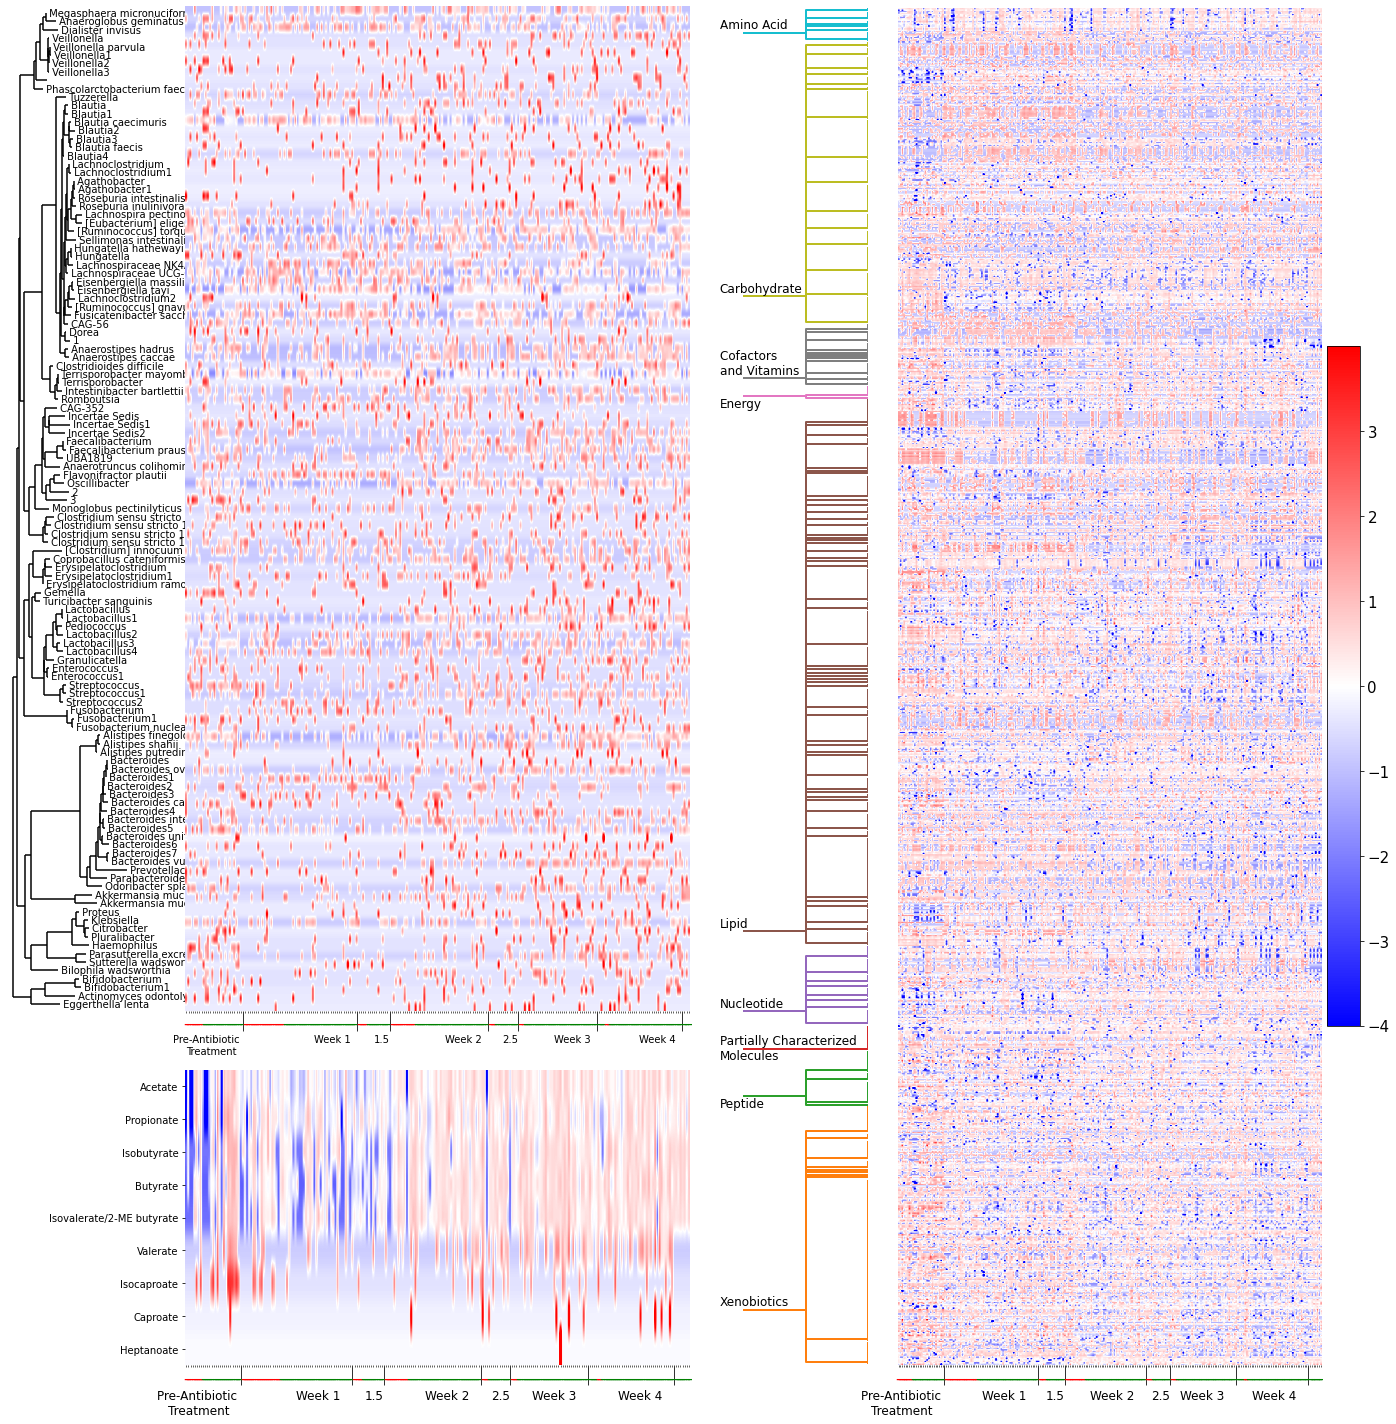

In [85]:
fig, ax = plt.subplots(figsize = (25,25), sharey = True, gridspec_kw = {'wspace':0, 'hspace':0})
ax_dendro = plt.subplot2grid((4, 8), (0, 4), colspan=1, rowspan = 4)
ax_metabs = plt.subplot2grid((4, 8),(0,5), colspan=3, rowspan = 4, sharey = ax_dendro)

ax_phylo = plt.subplot2grid((4,8),(0,0), colspan = 1, rowspan = 3)
ax_otus = plt.subplot2grid((4,8),(0,1), colspan = 3, rowspan = 3)

ax_scfa = plt.subplot2grid((4,8), (3,1), colspan = 3, rowspan = 1)
dat_16s = dl_2.keys['16s']

fig, ax_dendro, ax_metabs= plot_metab_heatmap(dl_1.keys['metabs'], dn, col_mat_df, fig, ax_dendro, ax_metabs, xlab_fontsize = 12,
                                              dendro_fontsize = 12, spaces = '   ')
fig, ax_scfa = plot_scfa_heatmap(dl_1.keys['scfa'], fig, ax_scfa)
fig, ax_phylo, ax_otus = plot_16s_heatmap(dat_16s, fig, ax_phylo, ax_otus, xlab_fontsize = 10, spaces = '  ')
# fig, ax_dendro, ax_metabs= plot_metab_heatmap(dat, dn, col_mat_df, fig, ax_dendro, ax_metabs, xlab_fontsize = 12,
#                                               dendro_fontsize = 12, spaces = '   ')


# fig, ax_dendro, ax_metabs = plot_metab_heatmap(dat, dn, col_mat_df, fig, ax_dendro, ax_metabs)
plt.savefig('paper_figs/fig2_heatmaps.pdf')

In [291]:
re_ix = dat['targets'].index.values[dat['targets']=='Recurrer']
cl_ix = dat['targets'].index.values[dat['targets']=='Non-recurrer']
tmpts = [x.split('-')[1] for x in dat['targets'].index.values]
t_ix_re = {}
t_ix_cl = {}
ix_list = []
x_ticks_minor_re = []
x_ticks_minor_cl = []
x_lab_min = []
x_ticks_major = []
x_lab_maj = []
# z_insert = []
for tmpt in np.unique(tmpts):
    temp = dat['targets'].index.values[np.where(np.array(tmpts)==tmpt)[0]]
    t_ix_re[tmpt] = sorted(list(set(temp).intersection(set(re_ix))))
    t_ix_cl[tmpt] = sorted(list(set(temp).intersection(set(cl_ix))))
#     if float(tmpt)>=0:
#         x_ticks_major.append(len(ix_list) +(int(len(t_ix_re[tmpt])) + int(len(t_ix_cl[tmpt]))/2))
#     elif float(tmpt)<=5:
#         x_ticks_major.append(len(ix_list) +(len(t_ix_re[tmpt])))
    
    if len(t_ix_re[tmpt])>0:
#         x_ticks_minor.append(len(ix_list)+int(len(t_ix_re[tmpt])/2))
        x_ticks_minor_re.extend(len(ix_list) + np.arange(len(t_ix_re[tmpt])))
        x_lab_min.extend(['-']*len(t_ix_re[tmpt]))
    ix_list.extend(t_ix_re[tmpt])
#     x_ticks_minor.append(len(ix_list)+int(len(t_ix_cl[tmpt])/2))
    x_ticks_minor_cl.extend(len(ix_list) + np.arange(len(t_ix_cl[tmpt])))
    
    ix_list.extend(t_ix_cl[tmpt])
#     z_insert.append(len(ix_list))
    x_lab_min.extend(['-']*len(t_ix_cl[tmpt]))
#     x_ticks_major.append(len(ix_list))
    if float(tmpt)<=4 and float(tmpt) != 3.5:
        x_ticks_major.append(len(ix_list))
        if tmpt.isnumeric():
            x_lab_maj.append('Week ' + str(tmpt) + '     ')
        else:
            x_lab_maj.append(str(tmpt))

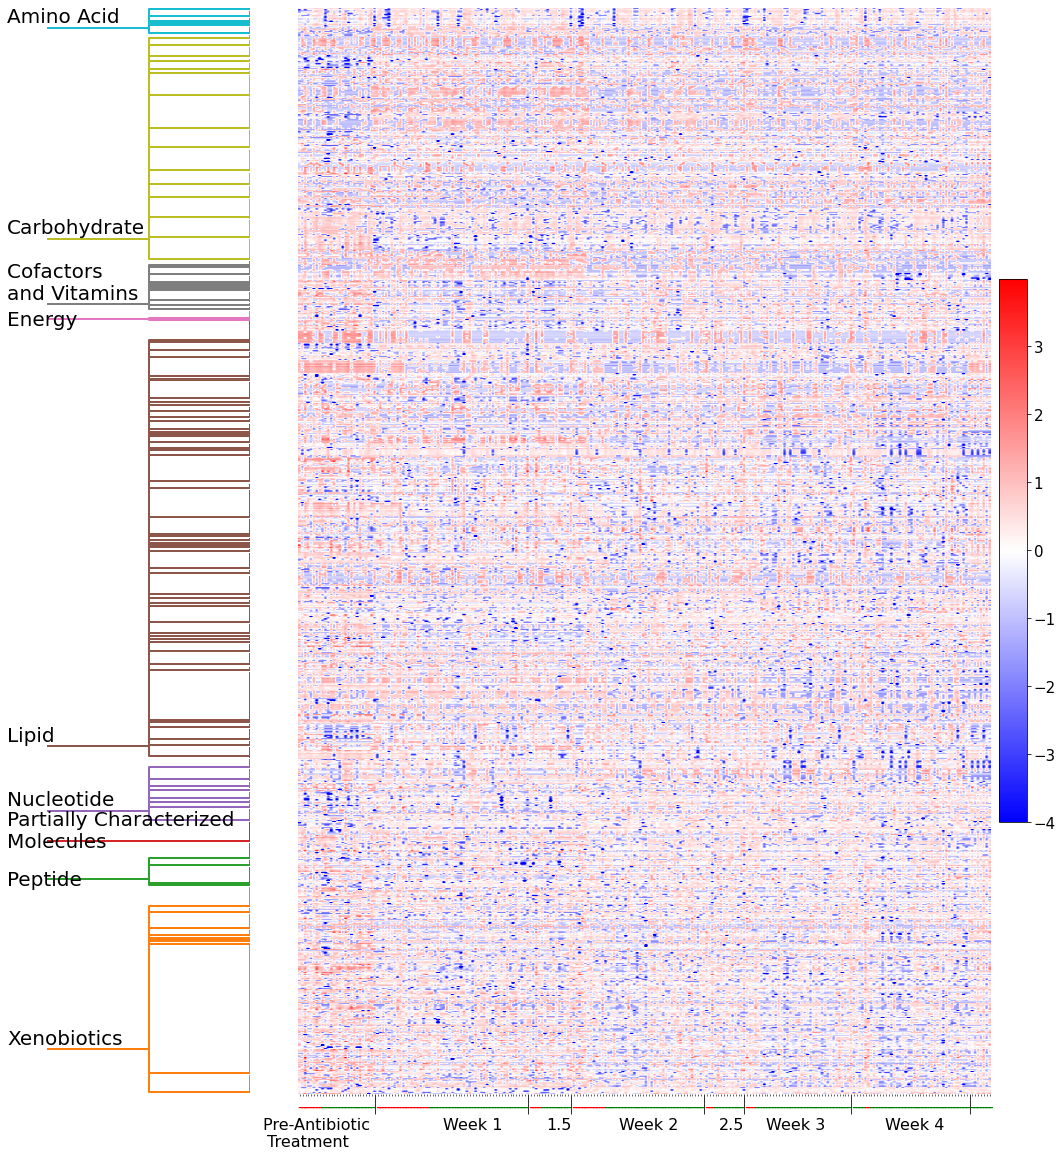

In [292]:
fig, ax = plt.subplots(figsize = (20,20), sharey = True, gridspec_kw = {'wspace':0, 'hspace':0})
df_dendro = col_mat_sorted[['SUPER_PATHWAY','SUB_PATHWAY']].astype('category')
ax_dendro = plt.subplot2grid((1, 4), (0, 0), colspan=1)
ax_metabs = plt.subplot2grid((1, 4),(0,1), colspan=3, sharey = ax_dendro)

x_vals = np.array(dn['dcoord'])
y_vals = np.array(dn['icoord'])
y_vals = (y_vals*data.shape[1])/np.max(y_vals)
line_cols = np.array(dn['color_list'])
df_dendro = df_dendro.replace('Partially Characterized Molecules','Partially Characterized \nMolecules')
df_dendro = df_dendro.replace('Cofactors and Vitamins', 'Cofactors \nand Vitamins')
super_pathways = np.unique(df_dendro.SUPER_PATHWAY)

ix = np.where(line_cols == 'C0')[0][0]
newy = np.array(list(y_vals[ix,:2])*2)
newx = np.array(list(x_vals[ix,:2])*2)
y_vals = np.insert(y_vals, [ix+1], newy, axis = 0)
x_vals = np.insert(x_vals, [ix+1], newx, axis = 0)
line_cols = np.insert(line_cols,ix, 'C0')
it = 0
locs = []
for i, col in enumerate(line_cols.copy()):
    if col == 'C0':
        if i == ix:
            y_vals[i,:] = np.array(list(y_vals[i,2:])*2)
            x_vals[i,:] = np.array(list(x_vals[i,2:])*2)
        else:
            y_vals[i,:] = np.array(list(y_vals[i,:2])*2)
            x_vals[i,:] = np.array(list(x_vals[i,:2])*2)
        col_ix = min(list(set(np.where(y_vals[:,2]>=y_vals[i,0])[0]).intersection(
                set(np.where(y_vals[:,0]<=y_vals[i,2])[0]))))
        line_cols[i] = line_cols[i].replace('C0',line_cols[col_ix])
        if len(locs)>1:
            if (locs[-1][1] - y_vals[i,0]) < np.max(y_vals)*.03:
                locs.append((1.20, y_vals[i,0] - np.max(y_vals)*.01))
            else:
                locs.append((1.20, y_vals[i,0] + np.max(y_vals)*.001))
        else:
            locs.append((1.20, y_vals[i,0] + np.max(y_vals)*.001))
#         annotation[(1.0, y_vals[i,0] + 10)] = super_pathways[it]
        it += 1
    
lines = [list(zip(x,y)) for x, y in zip(x_vals, y_vals)]
segments = LineCollection(lines, linewidths = (2,2,2,2), colors = line_cols)
ax_dendro.set_xlim(np.max(x_vals.tolist())+.2,np.min(x_vals.tolist()))
ax_dendro.set_ylim(np.min(y_vals.tolist())-1, np.max(y_vals.tolist())+1)
ax_dendro.add_collection(segments)
ax_dendro.set_frame_on(False)
ax_dendro.axes.get_xaxis().set_visible(False)
ax_dendro.axes.get_yaxis().set_visible(False)

for loc, text in zip(locs, super_pathways):
    ax_dendro.annotate(text, loc, va = 'bottom', fontsize = 20)
    
data = data[biochem_sorted]

metabs = data.columns.values
data_sorted = data.loc[ix_list]

pos = ax_metabs.imshow(np.array(data_sorted).T, cmap=plt.get_cmap('bwr'), vmin = -4, vmax = 4, aspect = 'auto');

ax_metabs.set_frame_on(False)
ax_metabs.axes.get_yaxis().set_visible(False)
cbar = fig.colorbar(pos, fraction=0.15, shrink=0.5, pad=0.01, ticks = np.arange(-4,4))
cbar.ax.tick_params(labelsize=15)

ax_metabs.set_xticks(x_ticks_major)
ax_metabs.tick_params(axis = 'x', which = 'major', length = 20)
ax_metabs.set_xticks(np.arange(data_sorted.shape[0]), minor = True)
ax_metabs.grid( False, axis='x' )
ax_metabs.grid( False, axis='x', which='minor' )

x_lab_maj = [xl.replace('Week 0','Pre-Antibiotic \nTreatment') for xl in x_lab_maj]
ax_metabs.set_xticklabels(labels=x_lab_maj, 
                   rotation = 0,  
                        ha = 'right', 
                  minor = False, fontsize = 16)
ax_metabs.set_xticklabels(labels = x_lab_min, 
                   minor = True, fontsize = 16)

for t, loc in zip(ax_metabs.xaxis.get_ticklabels(minor = True), 
                ax_metabs.xaxis.get_ticklocs(minor = True)):
    if loc in x_ticks_minor_re:
        t.set_color('red')
    if loc in x_ticks_minor_cl:
        t.set_color('green')

# ax_metabs.set_frame_on(False)
# ax_metabs.axes.get_yaxis().set_visible(False)
# ax_metabs.axes.get_xaxis().set_visible(False)
# ax_metabs.set_xlabel('Participants Over Time')
# cbar = fig.colorbar(pos, fraction=0.15, shrink=0.5, pad=0.01, ticks = np.arange(-4,4))
# cbar.ax.tick_params(labelsize=15)
plt.savefig('paper_figs/metabs_heatmap.pdf')

In [17]:
def lookup_by_names(tree, otu_dict):
    names = {}
    duplicates = {}
    for clade in tree.find_clades():
        if clade.name:
            otu_order.append(clade.name)
            clade.name= ' '.join(list(otu_dict[clade.name]['tax'].dropna())[5:])
#             print(clade.name)
            if clade.name in names.values():
                duplicates[clade.name] += 1
                clade.name = clade.name + str(duplicates[clade.name])
#                 raise ValueError("Duplicate key: %s" % clade.name)
            else:
                duplicates[clade.name] = 0
            names[clade] = clade.name
            
    return names, otu_order

In [9]:
from ete3 import Tree, ClusterTree, TextFace

In [297]:
re_ix = dl_2.keys['16s']['targets'].index.values[dl_2.keys['16s']['targets']=='Recurrer']
cl_ix = dl_2.keys['16s']['targets'].index.values[dl_2.keys['16s']['targets']=='Non-recurrer']
tmpts = [x.split('-')[1] for x in dl_2.keys['16s']['targets'].index.values]
t_ix_re = {}
t_ix_cl = {}
ix_list = []
x_ticks_minor_re = []
x_ticks_minor_cl = []
x_lab_min = []
x_ticks_major = []
x_lab_maj = []
# z_insert = []
for tmpt in np.unique(tmpts):
    temp = dl_2.keys['16s']['targets'].index.values[np.where(np.array(tmpts)==tmpt)[0]]
    t_ix_re[tmpt] = sorted(list(set(temp).intersection(set(re_ix))))
    t_ix_cl[tmpt] = sorted(list(set(temp).intersection(set(cl_ix))))
#     if float(tmpt)>=0:
#         x_ticks_major.append(len(ix_list) +(int(len(t_ix_re[tmpt])) + int(len(t_ix_cl[tmpt]))/2))
#     elif float(tmpt)<=5:
#         x_ticks_major.append(len(ix_list) +(len(t_ix_re[tmpt])))
    
    if len(t_ix_re[tmpt])>0:
#         x_ticks_minor.append(len(ix_list)+int(len(t_ix_re[tmpt])/2))
        x_ticks_minor_re.extend(len(ix_list) + np.arange(len(t_ix_re[tmpt])))
        x_lab_min.extend(['-']*len(t_ix_re[tmpt]))
    ix_list.extend(t_ix_re[tmpt])
#     x_ticks_minor.append(len(ix_list)+int(len(t_ix_cl[tmpt])/2))
    x_ticks_minor_cl.extend(len(ix_list) + np.arange(len(t_ix_cl[tmpt])))
    
    ix_list.extend(t_ix_cl[tmpt])
#     z_insert.append(len(ix_list))
    x_lab_min.extend(['-']*len(t_ix_cl[tmpt]))
#     x_ticks_major.append(len(ix_list))
    if float(tmpt)<=4 and float(tmpt) != 3.5:
        x_ticks_major.append(len(ix_list))
        if tmpt.isnumeric():
            x_lab_maj.append('Week ' + str(tmpt) + '  ')
        else:
            x_lab_maj.append(str(tmpt))

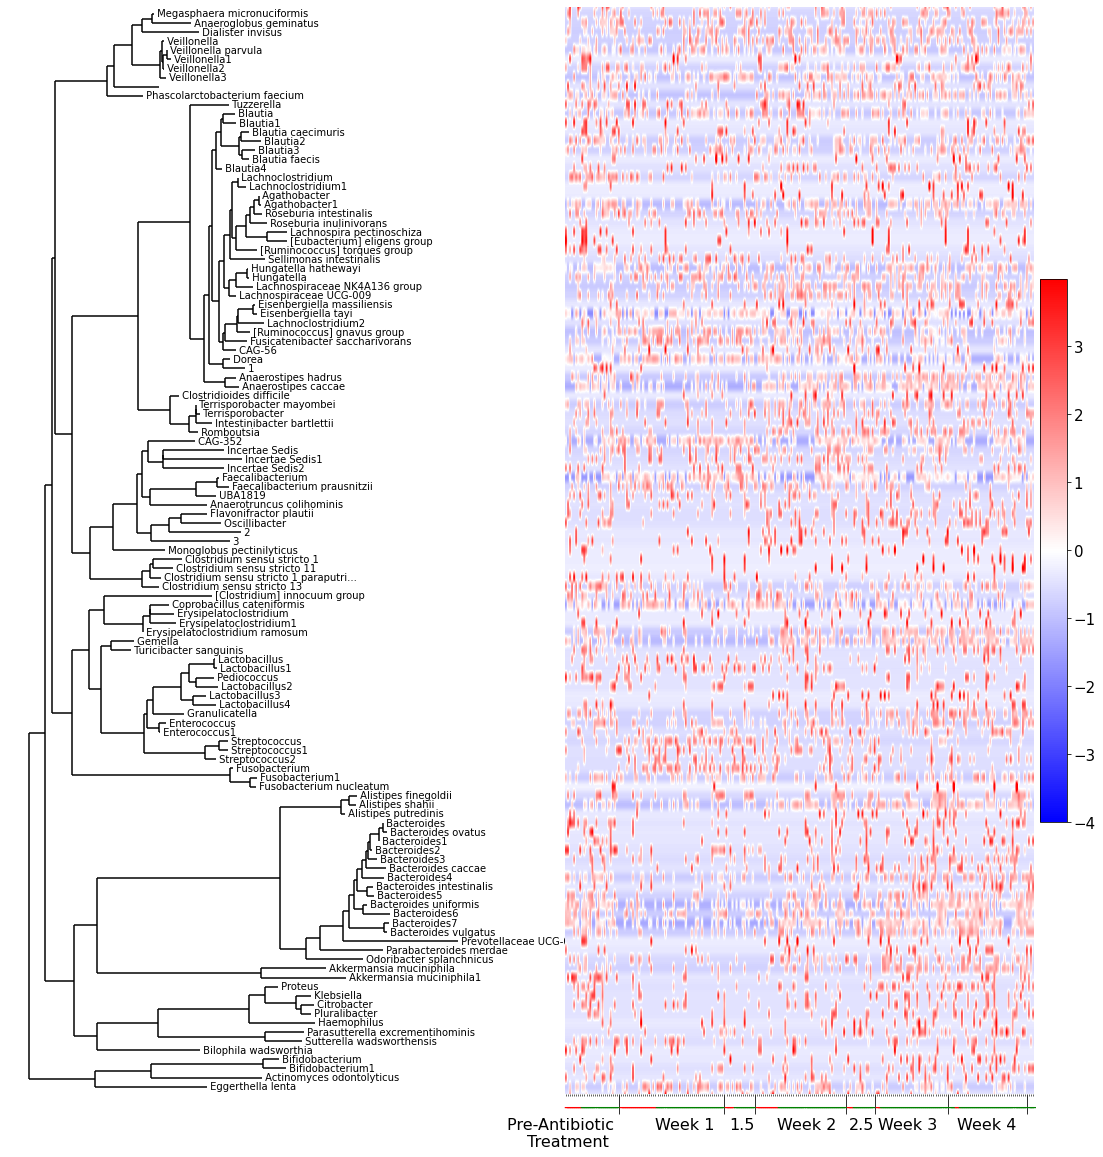

In [298]:
fig, (ax_phylo, ax_otus) = plt.subplots(1,2,figsize = (20,20), sharey = True, gridspec_kw = {'wspace':0, 'hspace':0})
# ax_phylo = plt.subplot2grid((1, 4), (0, 0), colspan=2)
# ax_otus = plt.subplot2grid((1, 4),(0,1), colspan=2, sharey = ax_phylo)

path = '/Users/jendawk/Dropbox (MIT)/Microbiome/CDIFF/CodeBase/phylo_tree_check_jan13/'
with open(path + 'inputs/asvs_to_place.txt') as file:  
    data = file.read().splitlines()

otus = data[::2]
seqs = data[1::2]

taxonomy = 'inputs/dada2-taxonomy-silva.csv'
taxdat = pd.read_csv(taxonomy)

otu_dict = {}
for i, otu in enumerate(otus):
    otu_dict[otu.split('>')[1]]={}
    otu_dict[otu.split('>')[1]]['seq'] = seqs[i]
    otu_dict[otu.split('>')[1]]['tax'] = taxdat[seqs[i]]

tree = Phylo.read('R analyses/tree_inputs/newick_tree_query_reads.nhx','newick')
names = lookup_by_names(tree, otu_dict)

otu_df = dl_2.keys['16s']['data']

seq_to_otu = {seq['seq']: otu for otu, seq in otu_dict.items()}
# otu_filt_df = otu_df.loc[otu_order]
otu_renamed = otu_df.rename(columns = seq_to_otu)
filt1 = otu_renamed[otu_order]

data_prop = np.divide(filt1.T, np.sum(filt1, 1)).T
epsilon = get_epsilon(data_prop)
geom_means = np.exp(np.mean(np.log(data_prop + epsilon), 1))
temp = np.divide(data_prop.T, geom_means).T
epsilon = get_epsilon(temp)
transformed = np.log(temp + epsilon)
stand = standardize(transformed, override=True)
stand = stand.loc[ix_list]

metabs = stand.columns.values

pos = ax_otus.imshow(np.array(stand).T, cmap=plt.get_cmap('bwr'), vmin = -4, vmax = 4, aspect = 'auto');

ax_otus.set_frame_on(False)
ax_otus.axes.get_yaxis().set_visible(False)
# ax_otus.axes.get_xaxis().set_visible(False)
cbar = fig.colorbar(pos, fraction=0.15, shrink=0.5, pad=0.01, ticks = np.arange(-4,4))
cbar.ax.tick_params(labelsize=15)

ax_otus.set_xticks(x_ticks_major)
ax_otus.tick_params(axis = 'x', which = 'major', length = 20)
ax_otus.set_xticks(np.arange(stand.shape[0]), minor = True)
ax_otus.grid( False, axis='x' )
ax_otus.grid( False, axis='x', which='minor' )

x_lab_maj = [xl.replace('Week 0','Pre-Antibiotic \nTreatment') for xl in x_lab_maj]
ax_otus.set_xticklabels(labels=x_lab_maj, 
                   rotation = 0,  
                        ha = 'right', 
                  minor = False, fontsize = 16)
ax_otus.set_xticklabels(labels = x_lab_min, 
                   minor = True, fontsize = 16)

for t, loc in zip(ax_otus.xaxis.get_ticklabels(minor = True), 
                ax_otus.xaxis.get_ticklocs(minor = True)):
    if loc in x_ticks_minor_re:
        t.set_color('red')
    if loc in x_ticks_minor_cl:
        t.set_color('green')
        

ax_phylo.set_frame_on(False)
ax_phylo.axes.get_yaxis().set_visible(False)
ax_phylo.axes.get_xaxis().set_visible(False)
Phylo.draw(tree, axes = ax_phylo,do_show=False)
plt.savefig('paper_figs/fig2_otus.pdf')